<a href="https://colab.research.google.com/github/elisaduan2005/chicago-crime-analysis/blob/main/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime
from datetime import date

#Clean violence data set
violence = pd.read_csv("violence.csv")

#Change everything to lower case
violence.columns = violence.columns.str.lower()

#Remove any leading spaces
violence.columns = violence.columns.str.lstrip()

#Replace spaces with underscore
violence.columns = violence.columns.str.replace(' ', '_')

#Delete any double spaces
violence.columns = violence.columns.str.replace('__', '_')

#Selecting data to analyze
violence1 = violence[["date", "victimization_primary"]]

#Changing data to appropriate format
violence1['date'] = pd.to_datetime(violence1['date'], format='%m/%d/%y %H:%M')
violence1['date'] = violence1['date'].dt.date
violence1['date'] = pd.to_datetime(violence1['date'])
violence1['year'] = violence1['date'].dt.year
violence1['month'] = violence1['date'].dt.month

#Filter for the specific crimes (given that there is sufficient data to train)
selected_crimes = ['HOMICIDE', 'BATTERY', 'ROBBERY']
violence1_filtered = violence1[violence1['victimization_primary'].isin(selected_crimes)]

#Group by year, month, and victimization_primary, then aggregate the count
violence_counts = violence1_filtered.groupby(['year', 'month', 'victimization_primary']).size().reset_index(name='count')


<ipython-input-1-6b0d79e6cba0>:6: DtypeWarning: Columns (25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  violence = pd.read_csv("violence.csv")
<ipython-input-1-6b0d79e6cba0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violence1['date'] = pd.to_datetime(violence1['date'], format='%m/%d/%y %H:%M')
<ipython-input-1-6b0d79e6cba0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violence1['date'] = violence1['date'].dt.date
<ipython-input-1-6b0d79e6cba0>:26: SettingW

In [ ]:
#Generate a dataframe with all combinations of year and month
years = range(1991, 2025)  #we are defining the range of years (1991-2024)
months = range(1, 13)      #Months 1 to 12
#creating a complete DataFrame for all combinations of year, month, and crime type
complete_combinations = pd.MultiIndex.from_product([years, months, ['HOMICIDE', 'BATTERY', 'ROBBERY']], names=['year', 'month', 'victimization_primary'])

#DataFrame with all combinations
complete_data = pd.DataFrame(index=complete_combinations).reset_index()

#Merge this with the original data to fill any missing months with zero
violence_counts = violence_counts[['year', 'month', 'victimization_primary', 'count']]
complete_data = pd.merge(complete_data, violence_counts, on=['year', 'month', 'victimization_primary'], how='left')

#Fill missing counts with 0
complete_data['count'] = complete_data['count'].fillna(0)

#filtering the data for each victimization type
battery_data = complete_data[complete_data['victimization_primary'] == 'BATTERY']
robbery_data = complete_data[complete_data['victimization_primary'] == 'ROBBERY']
homicide_data = complete_data[complete_data['victimization_primary'] == 'HOMICIDE']

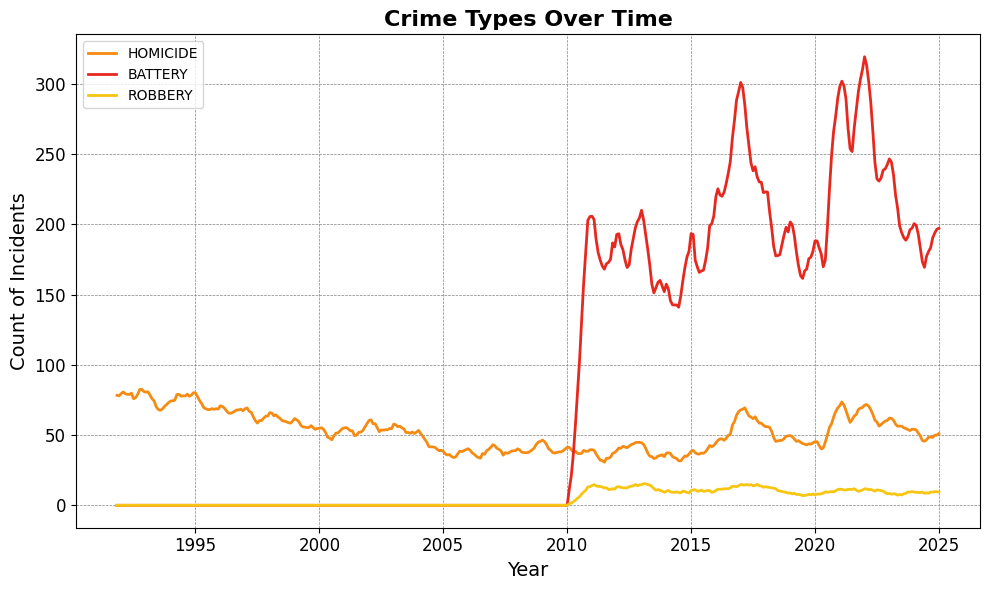

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#New function to plot the smoothed trends for multiple victimization types in one plot
def plot_all_victim_trends(data, victim_types):
    colors = ['#F68B12','#E6281F','#F6C612']
    fig, ax = plt.subplots(figsize=(10, 6))

    #go through each victimization type and plot its smoothed trend
    for i, victim_type in enumerate(victim_types):
        #filtering data for the specific victimization type
        victim_data = data[data['victimization_primary'] == victim_type]

        #grouping by year and month to get total incidents for each month
        victim_data2 = victim_data.groupby(['year', 'month'])['count'].sum().reset_index()

        #moving average smoothing
        window_size = 10
        smoothed_data = victim_data2['count'].rolling(window=window_size).mean()


        plt.plot(victim_data2['year'] + victim_data2['month'] / 12, smoothed_data,
                 label=f"{victim_type}", color=colors[i], linewidth=2)
  #smoothed trends
    plt.title("Crime Types Over Time", fontweight='bold', fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Count of Incidents", fontsize=14)
    plt.legend()
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()

victim_types = ['HOMICIDE', 'BATTERY', 'ROBBERY']
plot_all_victim_trends(complete_data, victim_types)

In [ ]:
import pandas as pd
#filtering for BATTERY and HOMICIDE because ROBBERY stays relatively flat
battery_homicide_data = complete_data[complete_data['victimization_primary'].isin(['BATTERY', 'HOMICIDE'])]

#grouping by year, month, and victimization type and find the max count
peaks_and_lows = battery_homicide_data.groupby(['year', 'month', 'victimization_primary'])['count'].max().reset_index()

#time periods to have max and min of different span of years
time_periods = [(2010, 2015), (2015, 2020), (2020, 2025)]

#new dictionary to store results
results = {}

#going through each time period and find the top 3 peaks and bottom 3 lows for each
for start_year, end_year in time_periods:
    period_data = peaks_and_lows[(peaks_and_lows['year'] >= start_year) & (peaks_and_lows['year'] < end_year)]

    #Getting the top 3 peaks
    battery_peaks = period_data[period_data['victimization_primary'] == 'BATTERY'].nlargest(3, 'count')
    homicide_peaks = period_data[period_data['victimization_primary'] == 'HOMICIDE'].nlargest(3, 'count')

    #Getting the bottom 3 lows
    battery_lows = period_data[period_data['victimization_primary'] == 'BATTERY'].nsmallest(3, 'count')
    homicide_lows = period_data[period_data['victimization_primary'] == 'HOMICIDE'].nsmallest(3, 'count')

    results[f'{start_year}-{end_year}'] = {
        'Battery Peaks': battery_peaks,
        'Homicide Peaks': homicide_peaks,
        'Battery Lows': battery_lows,
        'Homicide Lows': homicide_lows
    }

#Show results
for period, result in results.items():
    print(f"\n{period}:")
    print("Top 3 Battery Peaks:")
    print(result['Battery Peaks'])
    print("Top 3 Homicide Peaks:")
    print(result['Homicide Peaks'])
    print("Bottom 3 Battery Lows:")
    print(result['Battery Lows'])
    print("Bottom 3 Homicide Lows:")
    print(result['Homicide Lows'])


2010-2015:
Top 3 Battery Peaks:
     year  month victimization_primary  count
518  2012      8               BATTERY  294.0
468  2010      7               BATTERY  285.0
516  2012      7               BATTERY  273.0
Top 3 Homicide Peaks:
     year  month victimization_primary  count
471  2010      8              HOMICIDE   57.0
493  2011      7              HOMICIDE   57.0
519  2012      8              HOMICIDE   55.0
Bottom 3 Battery Lows:
     year  month victimization_primary  count
554  2014      2               BATTERY   50.0
482  2011      2               BATTERY   66.0
530  2013      2               BATTERY   69.0
Bottom 3 Homicide Lows:
     year  month victimization_primary  count
531  2013      2              HOMICIDE   13.0
533  2013      3              HOMICIDE   18.0
457  2010      1              HOMICIDE   20.0

2015-2020:
Top 3 Battery Peaks:
     year  month victimization_primary  count
610  2016      6               BATTERY  360.0
614  2016      8               BATTER

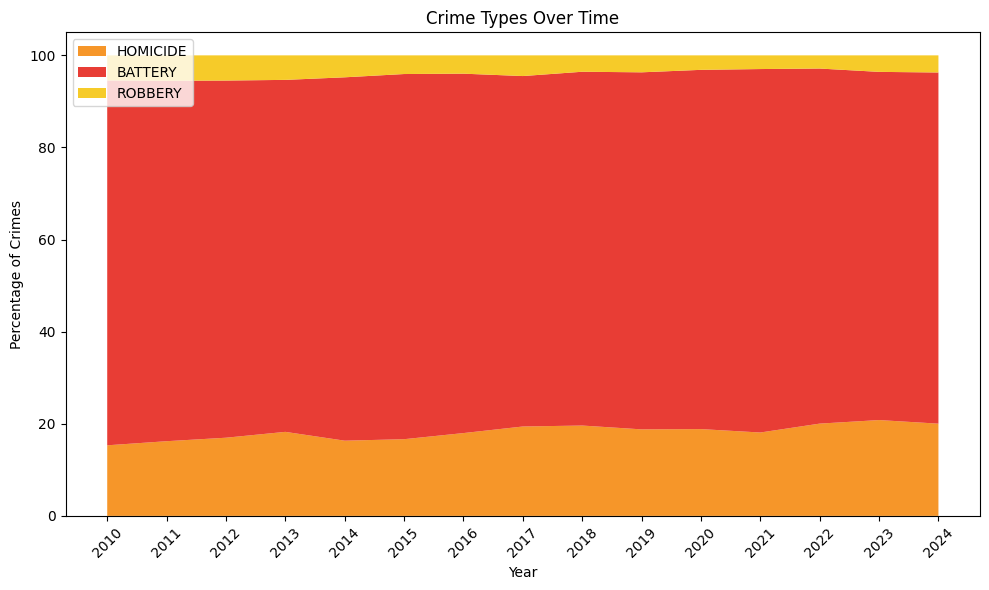

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#F68B12','#E6281F','#F6C612']
#make sure data is starting in 2010 when the three of the types of crimes start to have data
complete_data = complete_data[complete_data["year"] >= 2010]
#pivot the data so each age group becomes a column
data_pivot = complete_data.pivot_table(index='year', columns='victimization_primary', values='count', aggfunc='sum', fill_value=0)
#normalize to percentage
data_percent = data_pivot.div(data_pivot.sum(axis=1), axis=0) * 100
#plotting the percentage stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(data_percent.index, data_percent['HOMICIDE'], data_percent['BATTERY'],
              data_percent['ROBBERY'],
              colors=colors, labels=['HOMICIDE', 'BATTERY', 'ROBBERY'], alpha=0.9)

#adding labels and title
plt.title('Crime Types Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Crimes')
plt.legend(loc='upper left')
plt.xticks(data_percent.index, rotation=45)
plt.tight_layout()


#show plot
plt.show()

**Whether there have been shifts in the demographic backgrounds of victims over the years**

In [ ]:
#separate the data we will use for each investigation
race_data = violence[['date', 'race']]
sex_data = violence[['date', 'sex']]
age_data = violence[['date', 'age']]

**Race Data Analysis**

In [ ]:
#remove all the unknowns
race_data = race_data[race_data['race'] != 'UNKNOWN']
count_per_day_race = race_data.groupby(['date', 'race']).size().reset_index(name='count')
count_per_day_race.fillna(0, inplace=True)

#Re sample data to daily counts
count_per_day_race.columns = count_per_day_race.columns.str.strip()
count_per_day_race.sort_index()

,date,race,count
0,1/1/00 1:00,BLK,1
1,1/1/01 2:30,BLK,1
2,1/1/01 9:30,BLK,1
3,1/1/02 14:58,BLK,1
4,1/1/02 17:30,BLK,1
...,...,...,...
51466,9/9/98 10:40,BLK,1
51467,9/9/98 11:18,BLK,1
51468,9/9/99 14:12,BLK,1
51469,9/9/99 22:18,BLK,1


In [ ]:
#verify how many data points per each race to see if its enough data to plot
race_counts = count_per_day_race.groupby('race')['count'].sum().reset_index()
race_counts

#We want to name API, I and WBH as other because we dont have enough data points to do a good plot
count_per_day_race.loc[count_per_day_race['race'].isin(['API', 'I', 'WBH']), 'race'] = 'OTHER'
count_per_day_race

,date,race,count
0,1/1/00 1:00,BLK,1
1,1/1/01 2:30,BLK,1
2,1/1/01 9:30,BLK,1
3,1/1/02 14:58,BLK,1
4,1/1/02 17:30,BLK,1
...,...,...,...
51466,9/9/98 10:40,BLK,1
51467,9/9/98 11:18,BLK,1
51468,9/9/99 14:12,BLK,1
51469,9/9/99 22:18,BLK,1


<ipython-input-9-4160fe806fd6>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  race_data['year'] = pd.to_datetime(race_data['date']).dt.year
<ipython-input-9-4160fe806fd6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data['year'] = pd.to_datetime(race_data['date']).dt.year
<ipython-input-9-4160fe806fd6>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  race_data['month'] = pd.to_datetime(race_data['date']).dt.month
<ipython-input-9-4160fe806fd6>:14: SettingWit

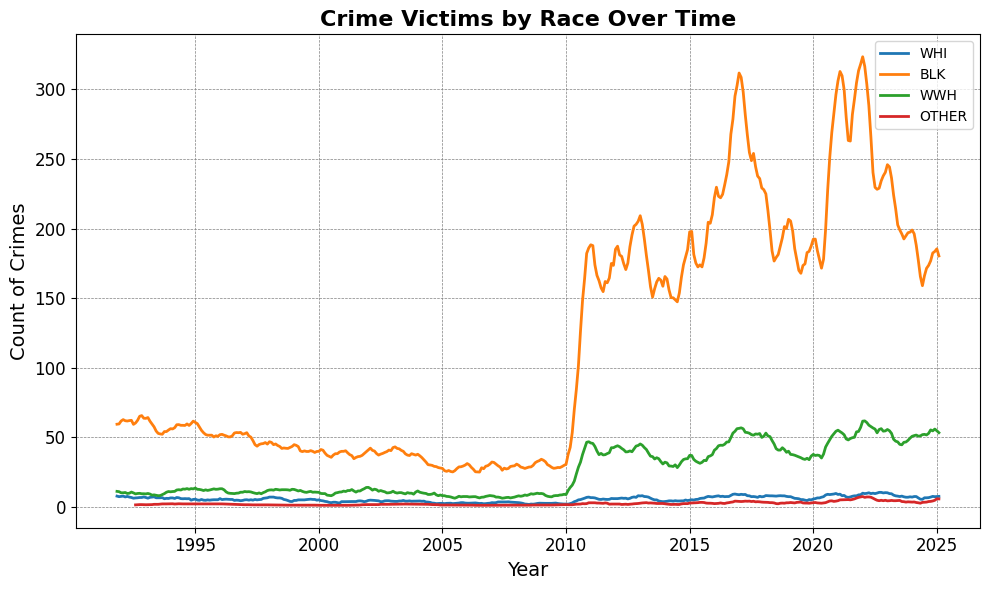

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#function to plot the smoothed trend for each race and combine them in one plot
def plot_trends(data, race_types):
    fig, ax = plt.subplots(figsize=(10, 6))
    for race_type in race_types:
        #filter the data to plot certain type of race
        race_data = data[data['race'] == race_type]

        #formatting date data again
        race_data['year'] = pd.to_datetime(race_data['date']).dt.year
        race_data['month'] = pd.to_datetime(race_data['date']).dt.month

        #group the data by year and month to get the count of crimes
        race_data_grouped = race_data.groupby(['year', 'month'])['count'].sum().reset_index()

        #moving Average smoothing
        window_size = 10
        smoothed_data = race_data_grouped['count'].rolling(window=window_size).mean()

        #plotting the smoothed trend for this race
        plt.plot(race_data_grouped['year'] + race_data_grouped['month'] / 12, smoothed_data,
                 label=f"{race_type}", linewidth=2)
    #plot smoothed curve
    plt.title("Crime Victims by Race Over Time", fontweight='bold', fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Count of Crimes", fontsize=14)
    plt.legend()
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()
race_types = ['WHI', 'BLK', 'WWH', 'OTHER']
#using function to plot all races on the same plot
plot_trends(count_per_day_race, race_types)

In [ ]:
import pandas as pd
#ONLY DID FOR BLK and WWH because the rest are relatively stable
count_per_day_race['date'] = pd.to_datetime(count_per_day_race['date'])
count_per_day_race['year'] = count_per_day_race['date'].dt.year
count_per_day_race['month'] = count_per_day_race['date'].dt.month

#time periods we want to analyze
time_periods = [(2010, 2015), (2015, 2020), (2020, 2025)]

races = ['BLK', 'WWH']
results = {}

#go through each time period
for start_year, end_year in time_periods:
    #filter the data for the specific time period
    period_data = count_per_day_race[(count_per_day_race['year'] >= start_year) & (count_per_day_race['year'] < end_year)]

    #dictionary for each time period
    period_results = {}

    #looping through each race type
    for race in races:
        #we want to filter data for the current race
        race_data = period_data[period_data['race'] == race]
        #Grouping by year, month, and race, then sum the 'count'
        race_data_grouped = race_data.groupby(['year', 'month', 'race'])['count'].sum().reset_index()

        #Finding the top 3 and bottom 3 data points
        top_3 = race_data_grouped.nlargest(3, 'count')
        bottom_3 = race_data_grouped.nsmallest(3, 'count')

        #storing the results for this race
        period_results[race] = {
            'Top 3': top_3,
            'Bottom 3': bottom_3
        }


    results[f'{start_year}-{end_year}'] = period_results

#Printing the results
for period, period_result in results.items():
    print(f"\n{period}:")
    for race, race_result in period_result.items():
        print(f"\nRace: {race}")
        print("Top 3 Data Points:")
        print(race_result['Top 3'])
        print("Bottom 3 Data Points:")
        print(race_result['Bottom 3'])


<ipython-input-10-bee57a4a9fb5>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count_per_day_race['date'] = pd.to_datetime(count_per_day_race['date'])



2010-2015:

Race: BLK
Top 3 Data Points:
    year  month race  count
31  2012      8  BLK    293
30  2012      7  BLK    277
6   2010      7  BLK    272
Bottom 3 Data Points:
    year  month race  count
49  2014      2  BLK     60
13  2011      2  BLK     62
37  2013      2  BLK     66

Race: WWH
Top 3 Data Points:
   year  month race  count
4  2010      5  WWH     64
7  2010      8  WWH     61
5  2010      6  WWH     59
Bottom 3 Data Points:
    year  month race  count
49  2014      2  WWH      9
45  2013     10  WWH     16
13  2011      2  WWH     18

2015-2020:

Race: BLK
Top 3 Data Points:
    year  month race  count
19  2016      8  BLK    379
18  2016      7  BLK    376
17  2016      6  BLK    370
Bottom 3 Data Points:
    year  month race  count
1   2015      2  BLK     53
48  2019      1  BLK     98
49  2019      2  BLK     98

Race: WWH
Top 3 Data Points:
    year  month race  count
31  2017      8  WWH     72
19  2016      8  WWH     68
20  2016      9  WWH     66
Bottom 3 D

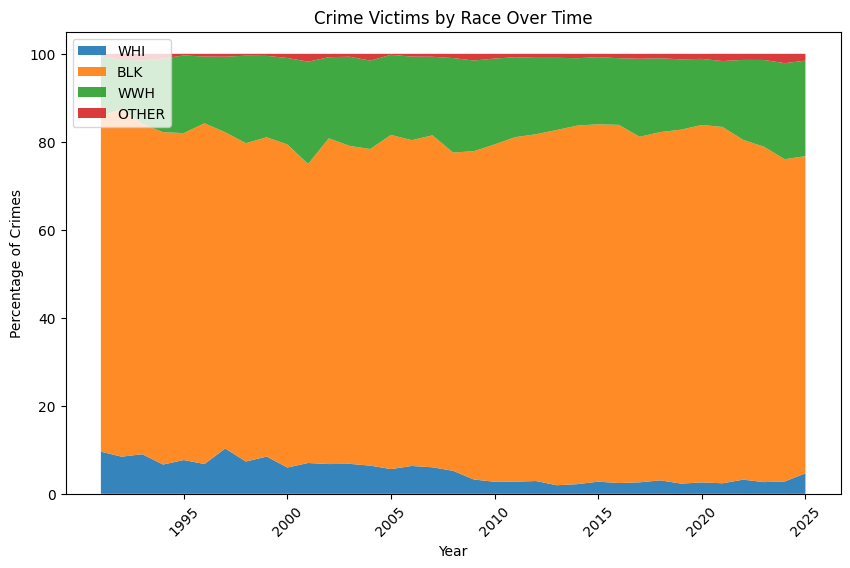

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

count_per_day_race['date'] = pd.to_datetime(count_per_day_race['date'])

#get year and age columns
count_per_day_race['year'] = count_per_day_race['date'].dt.year
count_per_day_race['month'] = count_per_day_race['date'].dt.month

#grouping the data by year and age to get the count of crimes
race_data_grouped = count_per_day_race.groupby(['year', 'race'])['count'].sum().reset_index()

#pivot the data
race_data_pivot = race_data_grouped.pivot_table(index='year', columns='race', values='count', aggfunc='sum', fill_value=0)

#normalize to percentage
race_data_percent = race_data_pivot.div(race_data_pivot.sum(axis=1), axis=0) * 100

#colors we want to use
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red' ]

#plot
plt.figure(figsize=(10, 6))
plt.stackplot(race_data_percent.index, race_data_percent['WHI'], race_data_percent['BLK'],
              race_data_percent['WWH'],
              race_data_percent['OTHER'],
              colors=colors, labels=['WHI', 'BLK', 'WWH', 'OTHER'], alpha=0.9)
#add labels and title
plt.title("Crime Victims by Race Over Time")
plt.xlabel('Year')
plt.ylabel('Percentage of Crimes')
plt.legend(loc='upper left')
#plt.xticks(np.arange(min(race_data_percent.index), max(race_data_percent.index)+1, 4), rotation=45)
plt.xticks(np.arange(1995, 2026, 5), rotation=45)

#plot
plt.show()

**Sex Data Analysis**

In [ ]:
#cleaning data
sex_data = sex_data[sex_data['sex'] != 'UNKNOWN']
count_per_day_sex = sex_data.groupby(['date', 'sex']).size().reset_index(name='count')
count_per_day_sex.fillna(0, inplace=True)

#Re sample data to daily counts
count_per_day_sex.columns = count_per_day_sex.columns.str.strip()
count_per_day_sex.sort_index()

,date,sex,count
0,1/1/00 1:00,F,1
1,1/1/01 2:30,M,1
2,1/1/01 9:30,F,1
3,1/1/02 14:58,M,1
4,1/1/02 17:30,M,1
...,...,...,...
53064,9/9/98 10:40,F,1
53065,9/9/98 11:18,M,1
53066,9/9/99 14:12,M,1
53067,9/9/99 22:18,M,1


<ipython-input-13-31d9c2768185>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sex_data['year'] = pd.to_datetime(sex_data['date']).dt.year
<ipython-input-13-31d9c2768185>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_data['year'] = pd.to_datetime(sex_data['date']).dt.year
<ipython-input-13-31d9c2768185>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sex_data['month'] = pd.to_datetime(sex_data['date']).dt.month
<ipython-input-13-31d9c2768185>:17: SettingWithC

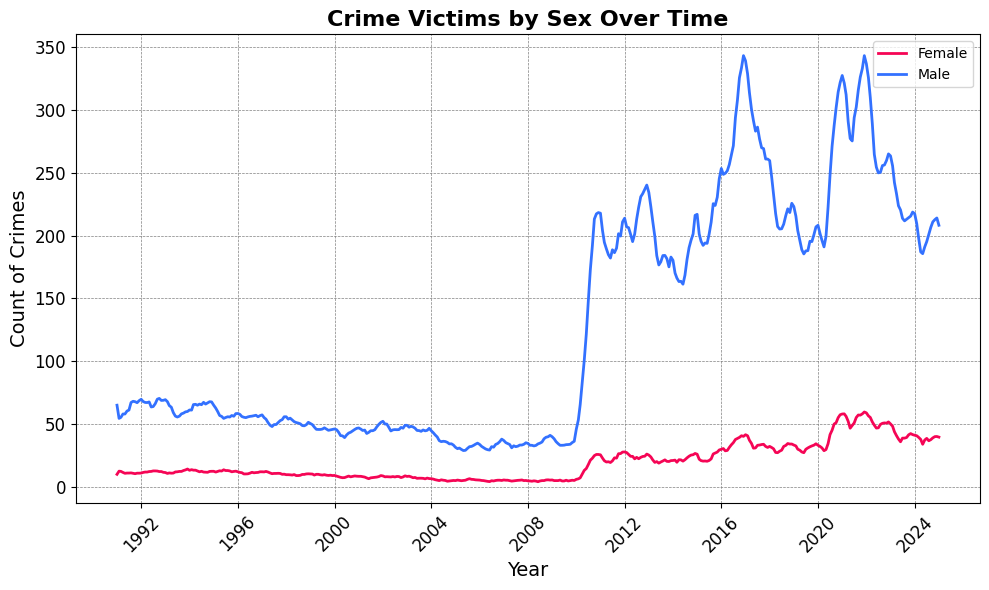

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sex_trends(data):
    #categories
    sex_types = ['F', 'M']


    fig, ax = plt.subplots(figsize=(10, 6))

    #go through over the sex types
    for sex_type in sex_types:
        sex_data = data[data['sex'] == sex_type]

        #format data
        sex_data['year'] = pd.to_datetime(sex_data['date']).dt.year
        sex_data['month'] = pd.to_datetime(sex_data['date']).dt.month

        #group the data by year and month
        sex_data_grouped = sex_data.groupby(['year', 'month'])['count'].sum().reset_index()

        #Moving Average smoothing
        window_size = 10
        smoothed_data = sex_data_grouped['count'].rolling(window=window_size, min_periods=1).mean()
        sex_data_grouped['date'] = pd.to_datetime(sex_data_grouped[['year', 'month']].assign(day=1))

        #plotting in the same plot
        if sex_type == 'F':
            ax.plot(sex_data_grouped['date'], smoothed_data,
                    label="Female", color='#F50555', linewidth=2)
        elif sex_type == 'M':
            ax.plot(sex_data_grouped['date'], smoothed_data,
                    label="Male", color='#3371FF', linewidth=2)

#plotting smoothed curve
    ax.set_title("Crime Victims by Sex Over Time", fontweight='bold', fontsize=16)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Count of Crimes", fontsize=14)
    ax.legend()
    plt.xticks(rotation=45)
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()


#call function with my data
plot_sex_trends(count_per_day_sex)


In [ ]:
import pandas as pd

count_per_day_sex['date'] = pd.to_datetime(count_per_day_sex['date'])
#extract 'year' and 'month'
count_per_day_sex['year'] = count_per_day_sex['date'].dt.year
count_per_day_sex['month'] = count_per_day_sex['date'].dt.month
#time periods for grouping
time_periods = [(2010, 2015), (2015, 2020), (2020, 2025)]
#define genders
genders = ['F', 'M']
#initialize dictionary to store results
results = {}
#loop through each time period
for start_year, end_year in time_periods:
    #filtering data
    period_data = count_per_day_sex[(count_per_day_sex['year'] >= start_year) & (count_per_day_sex['year'] < end_year)]
    #initializing dictionaries
    period_results = {}

    #looping through each gender type
    for gender in genders:
        #filtering the data for the current gender
        gender_data = period_data[period_data['sex'] == gender]

        #grouping data
        gender_data_grouped = gender_data.groupby(['year', 'month', 'sex'])['count'].sum().reset_index()

        #find the top 3 and bottom 3 data points
        top_3 = gender_data_grouped.nlargest(3, 'count')
        bottom_3 = gender_data_grouped.nsmallest(3, 'count')


        period_results[gender] = {
            'Top 3': top_3,
            'Bottom 3': bottom_3
        }


    results[f'{start_year}-{end_year}'] = period_results

#results
for period, period_result in results.items():
    print(f"\n{period}:")
    for gender, gender_result in period_result.items():
        print(f"\nSex: {gender}")
        print("Top 3 Data Points:")
        print(gender_result['Top 3'])
        print("Bottom 3 Data Points:")
        print(gender_result['Bottom 3'])


<ipython-input-14-a5e8dde115bf>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count_per_day_sex['date'] = pd.to_datetime(count_per_day_sex['date'])



2010-2015:

Sex: F
Top 3 Data Points:
    year  month sex  count
19  2011      8   F     48
21  2011     10   F     46
51  2014      4   F     43
Bottom 3 Data Points:
    year  month sex  count
37  2013      2   F      6
13  2011      2   F      7
39  2013      4   F      8

Sex: M
Top 3 Data Points:
    year  month sex  count
31  2012      8   M    329
30  2012      7   M    311
6   2010      7   M    295
Bottom 3 Data Points:
    year  month sex  count
49  2014      2   M     63
13  2011      2   M     81
37  2013      2   M     85

2015-2020:

Sex: F
Top 3 Data Points:
    year  month sex  count
18  2016      7   F     70
17  2016      6   F     56
16  2016      5   F     55
Bottom 3 Data Points:
    year  month sex  count
1   2015      2   F      3
0   2015      1   F     13
35  2017     12   F     14

Sex: M
Top 3 Data Points:
    year  month sex  count
19  2016      8   M    420
21  2016     10   M    395
17  2016      6   M    393
Bottom 3 Data Points:
    year  month sex  cou

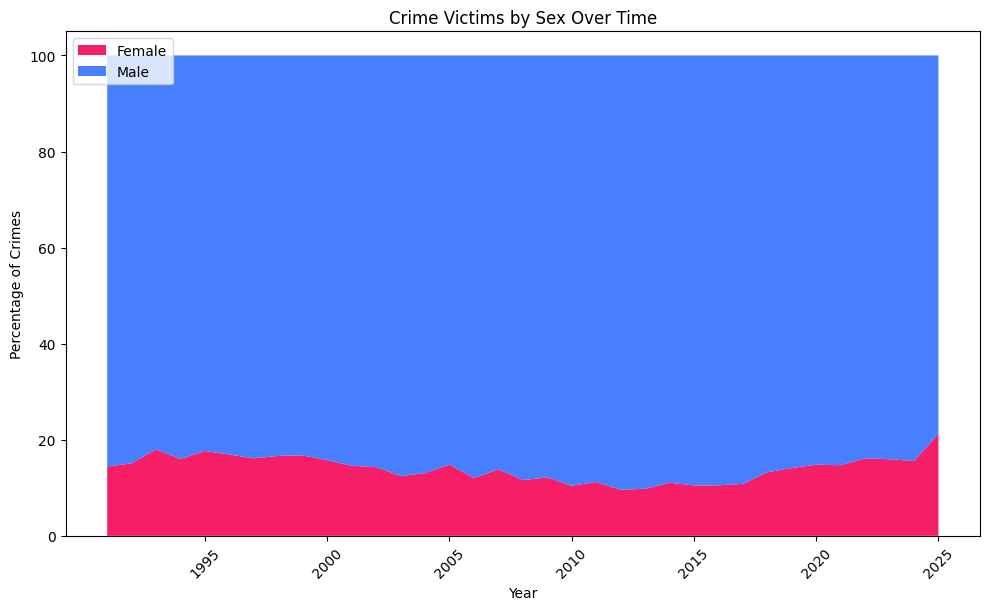

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

count_per_day_sex['date'] = pd.to_datetime(count_per_day_sex['date'])
#extract year and age columns
count_per_day_sex['year'] = count_per_day_sex['date'].dt.year
count_per_day_sex['month'] = count_per_day_sex['date'].dt.month

#group the data by year and age to get the count of crimes
sex_data_grouped = count_per_day_sex.groupby(['year', 'sex'])['count'].sum().reset_index()

#pivot the data
sex_data_pivot = sex_data_grouped.pivot_table(index='year', columns='sex', values='count', aggfunc='sum', fill_value=0)

#normalize to percentage
sex_data_percent = sex_data_pivot.div(sex_data_pivot.sum(axis=1), axis=0) * 100

#my selected colors
colors = ["#F50555",'#3371FF' ]

#plot
plt.figure(figsize=(10, 6))
plt.stackplot(sex_data_percent.index, sex_data_percent['F'], sex_data_percent['M'],
              colors=colors, labels=['Female', 'Male'], alpha=0.9)


plt.title('Crime Victims by Sex Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Crimes')
plt.legend(loc='upper left')
plt.tight_layout()
plt.xticks(np.arange(1995,2026, 5), rotation=45)
# Show plot
plt.show()


**AGE DATA ANALYSIS**

In [ ]:
#AGE DATA
age_data = violence[['date', 'age']]
age_data = age_data[age_data['age'] != 'UNKNOWN']
count_per_day_age = age_data.groupby(['date', 'age']).size().reset_index(name='count')
count_per_day_age.fillna(0, inplace=True)

#Re sample data to daily counts -> we decided to group data from 40+ to have enough data points
count_per_day_age.columns = count_per_day_age.columns.str.strip()
count_per_day_age.sort_index()
count_per_day_age['age'] = count_per_day_age['age'].replace({'60-69': '40+', '70-79': '40+', '80+': '40+', '40-49': '40+', '50-59': '40+' })
count_per_day_age

#see the data
age_counts = count_per_day_age.groupby('age')['count'].sum().reset_index()
age_counts

count_per_day_age

,date,age,count
0,1/1/00 1:00,30-39,1
1,1/1/01 2:30,20-29,1
2,1/1/01 9:30,20-29,1
3,1/1/02 14:58,20-29,1
4,1/1/02 17:30,40+,1
...,...,...,...
55315,9/9/98 10:40,20-29,1
55316,9/9/98 11:18,0-19,1
55317,9/9/99 14:12,0-19,1
55318,9/9/99 22:18,20-29,1


<ipython-input-17-12c1aabccfdf>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  age_data['year'] = pd.to_datetime(age_data['date']).dt.year
<ipython-input-17-12c1aabccfdf>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['year'] = pd.to_datetime(age_data['date']).dt.year
<ipython-input-17-12c1aabccfdf>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  age_data['month'] = pd.to_datetime(age_data['date']).dt.month
<ipython-input-17-12c1aabccfdf>:23: SettingWithC

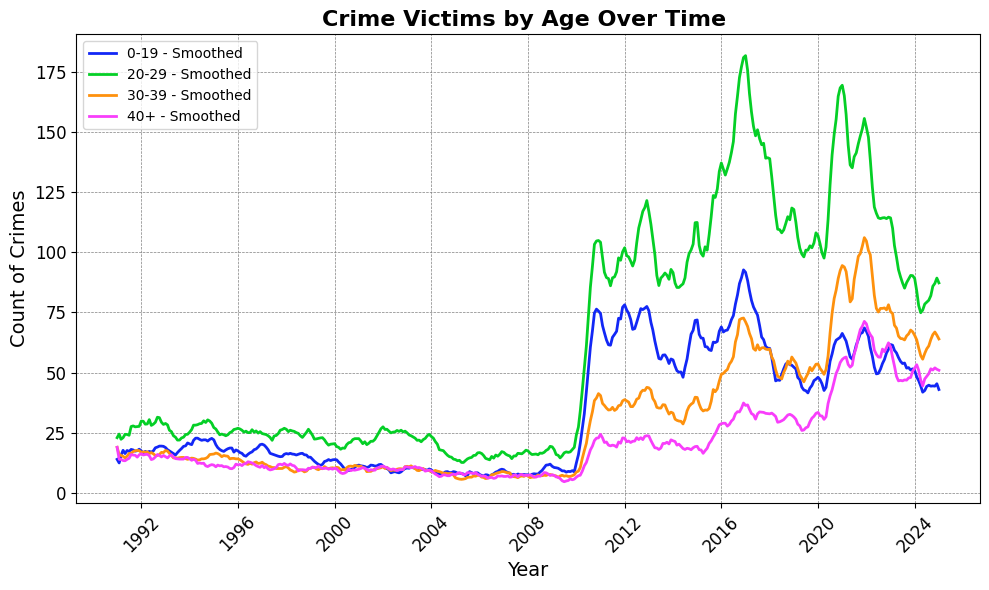

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#new function to plot smoothed crime trends for each age group
def plot_smoothed_crime_trends(data):
    #list of age groups to compare
    age_groups = ['0-19', '20-29', '30-39', '40+']
    #figure to plot on the same axes
    fig, ax = plt.subplots(figsize=(10, 6))

    #go through over age groups to plot smoothed curves
    for age_group in age_groups:
        #filtering data for the current age group
        age_data = data[data['age'] == age_group]

        #check if there is enough data
        if len(age_data) < 2:
            print(f"Not enough data for {age_group}")
            continue

        #format the date data
        age_data['year'] = pd.to_datetime(age_data['date']).dt.year
        age_data['month'] = pd.to_datetime(age_data['date']).dt.month

        #group the data by year and month to get the count of crimes
        age_data_grouped = age_data.groupby(['year', 'month'])['count'].sum().reset_index()

        #Moving Average smoothing
        window_size = 10
        smoothed_data = age_data_grouped['count'].rolling(window=window_size, min_periods=1).mean()

        #year and month into a single datetime for proper plotting on the x-axis
        age_data_grouped['date'] = pd.to_datetime(age_data_grouped[['year', 'month']].assign(day=1))

        #plot the smoothed counts over time for the current age group
        if age_group == '0-19':
            ax.plot(age_data_grouped['date'], smoothed_data,
                    label="0-19 - Smoothed", color='#1227F6', linewidth=2)
        elif age_group == '20-29':
            ax.plot(age_data_grouped['date'], smoothed_data,
                    label="20-29 - Smoothed", color='#04CF26', linewidth=2)
        elif age_group == '30-39':
            ax.plot(age_data_grouped['date'], smoothed_data,
                    label="30-39 - Smoothed", color='#FE910D', linewidth=2)
        elif age_group == '40+':
            ax.plot(age_data_grouped['date'], smoothed_data,
                    label="40+ - Smoothed", color='#f83efb', linewidth=2)

    #Smoothed plot
    ax.set_title("Crime Victims by Age Over Time ", fontweight='bold', fontsize=16)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Count of Crimes", fontsize=14)
    ax.legend()
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#call the function with your data
plot_smoothed_crime_trends(count_per_day_age)



In [ ]:
import pandas as pd

count_per_day_age['date'] = pd.to_datetime(count_per_day_age['date'])
count_per_day_age['year'] = count_per_day_age['date'].dt.year
count_per_day_age['month'] = count_per_day_age['date'].dt.month

#time periods we ant to analyze
time_periods = [(2010, 2015), (2015, 2020), (2020, 2025)]

#age groups
age_groups = ['0-19', '20-29', '30-39', '40+']
results = {}

#going through time periods
for start_year, end_year in time_periods:
    # Filter data for the specific time period
    period_data = count_per_day_age[(count_per_day_age['year'] >= start_year) & (count_per_day_age['year'] < end_year)]

    #dictionaries
    period_results = {}

    #looping through age groups
    for age_group in age_groups:
        age_group_data = period_data[period_data['age'] == age_group]
        #grouping by year, month, and age group, then sum the 'count'
        age_group_data_grouped = age_group_data.groupby(['year', 'month', 'age'])['count'].sum().reset_index()
        #finding the top 3 and bottom 3 data points
        top_3 = age_group_data_grouped.nlargest(3, 'count')
        bottom_3 = age_group_data_grouped.nsmallest(3, 'count')
        #storing the results for this age group
        period_results[age_group] = {
            'Top 3': top_3,
            'Bottom 3': bottom_3
        }


    results[f'{start_year}-{end_year}'] = period_results
for period, period_result in results.items():
    print(f"\n{period}:")
    for age_group, age_group_result in period_result.items():
        print(f"\nAge Group: {age_group}")
        print("Top 3 Data Points:")
        print(age_group_result['Top 3'])
        print("Bottom 3 Data Points:")
        print(age_group_result['Bottom 3'])


<ipython-input-18-375082037822>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  count_per_day_age['date'] = pd.to_datetime(count_per_day_age['date'])



2010-2015:

Age Group: 0-19
Top 3 Data Points:
    year  month   age  count
31  2012      8  0-19    118
18  2011      7  0-19    109
6   2010      7  0-19    104
Bottom 3 Data Points:
    year  month   age  count
49  2014      2  0-19     20
13  2011      2  0-19     21
37  2013      2  0-19     24

Age Group: 20-29
Top 3 Data Points:
    year  month    age  count
31  2012      8  20-29    173
30  2012      7  20-29    162
55  2014      8  20-29    144
Bottom 3 Data Points:
    year  month    age  count
49  2014      2  20-29     28
37  2013      2  20-29     42
48  2014      1  20-29     47

Age Group: 30-39
Top 3 Data Points:
    year  month    age  count
6   2010      7  30-39     56
43  2013      8  30-39     56
9   2010     10  30-39     55
Bottom 3 Data Points:
    year  month    age  count
1   2010      2  30-39     10
13  2011      2  30-39     15
49  2014      2  30-39     16

Age Group: 40+
Top 3 Data Points:
    year  month  age  count
43  2013      8  40+     38
21  2011 

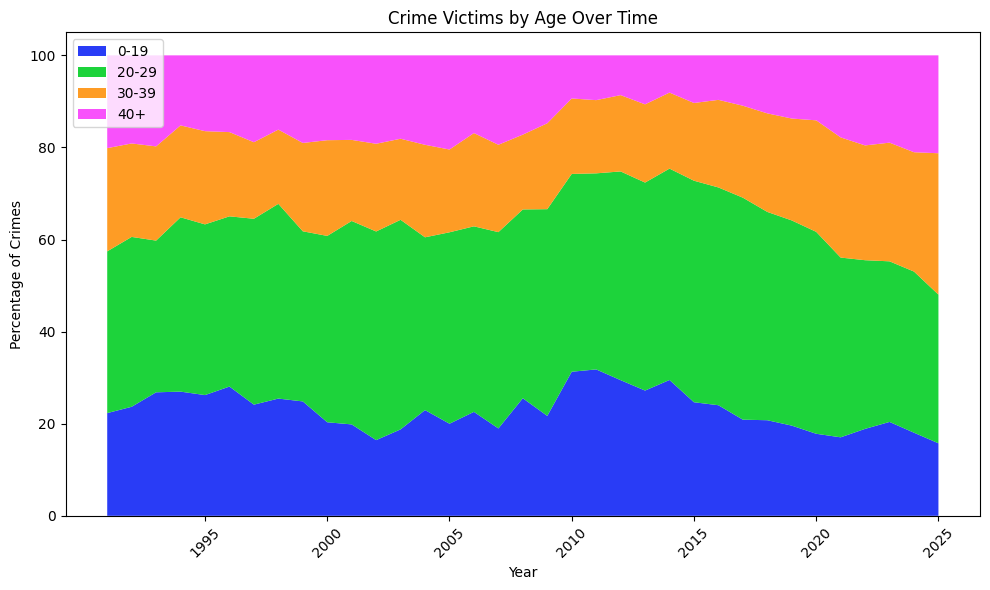

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

count_per_day_age['date'] = pd.to_datetime(count_per_day_age['date'])

#extract year and age columns
count_per_day_age['year'] = count_per_day_age['date'].dt.year
count_per_day_age['month'] = count_per_day_age['date'].dt.month

#group the data by year and age to get the count of crimes
age_data_grouped = count_per_day_age.groupby(['year', 'age'])['count'].sum().reset_index()

#pivot the data
age_data_pivot = age_data_grouped.pivot_table(index='year', columns='age', values='count', aggfunc='sum', fill_value=0)

#normalize to percentage
age_data_percent = age_data_pivot.div(age_data_pivot.sum(axis=1), axis=0) * 100

#colors I wanted to use
colors = ["#1227F6", '#04CF26', '#FE910D', '#f83efb']

#plot
plt.figure(figsize=(10, 6))
plt.stackplot(age_data_percent.index, age_data_percent['0-19'], age_data_percent['20-29'],
              age_data_percent['30-39'], age_data_percent['40+'], labels=['0-19', '20-29', '30-39', '40+'],
              colors=colors, alpha=0.9)
plt.title('Crime Victims by Age Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Crimes')
plt.legend(loc='upper left')
plt.xticks(np.arange(1995, 2026, 5), rotation=45)
plt.tight_layout()
plt.show()
